# Problem Statement
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

## Data description
1. **city**: city this user signed up in
2. **phone**: primary device for this user
3. **signup_date**: date of account registration; in the form ‘YYYYMMDD’
4. **last_trip_date**: the last time this user completed a trip; in the form ‘YYYYMMDD’
5. **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
6. **avg_rating_by_driver**: the rider’s average rating over all of their trips
7. **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
8. **surge_pct**: the percent of trips taken with surge multiplier > 1
9. **avg_surge**: The average surge multiplier over all of this user’s trips
10. **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up
11. **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
12. **weekday_pct**: the percent of the user’s trips occurring during a weekday

In [1]:
# import
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load and preview data
file = 'ultimate_data_challenge.json'
df = pd.read_json(file)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
# enforce data types
dtype_dict = {
    'city'                   : 'category',
    'trips_in_first_30_days' : 'int64',
    'signup_date'            : 'datetime64[ns]',
    'avg_rating_of_driver'   : 'float64',
    'avg_surge'              : 'float64',
    'last_trip_date'         : 'datetime64[ns]',
    'phone'                  : 'category',
    'surge_pct'              : 'float64',
    'ultimate_black_user'    : 'bool',
    'weekday_pct'            : 'float64',
    'avg_dist'               : 'float64',
    'avg_rating_by_driver'   : 'float64'
}

for col in df.columns:
    df[col] = df[col].astype(dtype_dict[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  category      
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  category      
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), fl

In [5]:
# check for null values
df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [6]:
# proportion of null values
print(df['avg_rating_of_driver'].isnull().sum() / df.shape[0])
print(df['avg_rating_by_driver'].isnull().sum() / df.shape[0])

0.16244
0.00402


In [7]:
# Let's drop the rows that contain NaNs
df.dropna(axis=0, inplace=True)

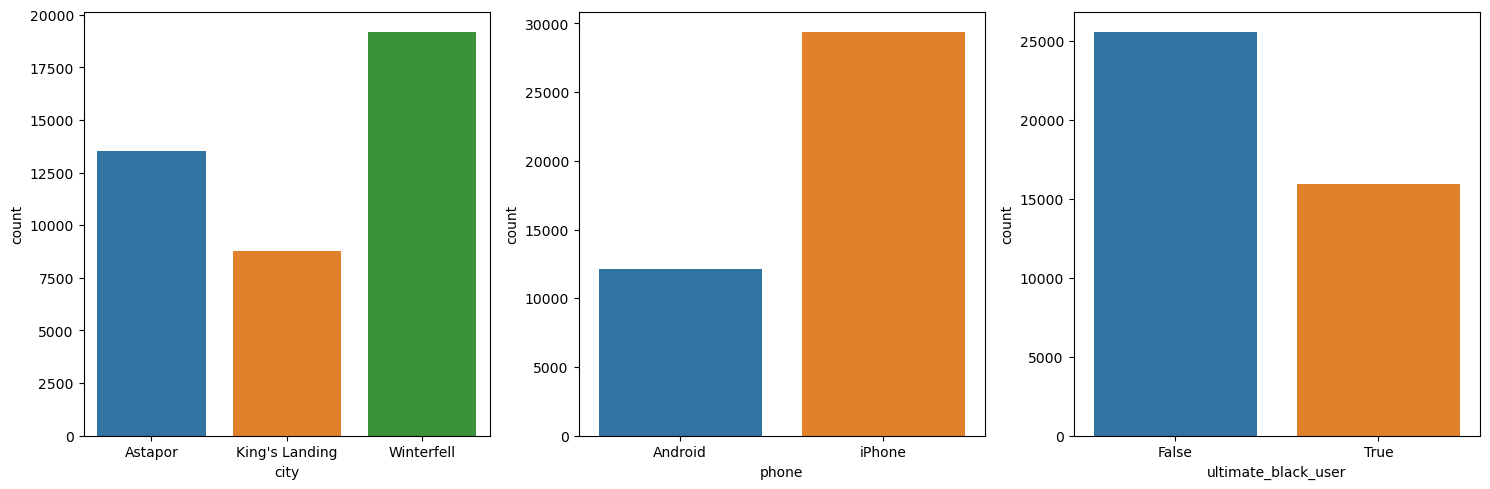

In [8]:
# view categorical data
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.countplot(ax=axs[0], x=df['city'])
sns.countplot(ax=axs[1], x=df['phone'])
sns.countplot(ax=axs[2], x=df['ultimate_black_user'])
plt.tight_layout()
plt.show()

In [9]:
# one-hot encode category and bool variables
df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [10]:
# convert bool to int8 for numerical processing
df[['city_Astapor',
    'city_King\'s Landing',
    'city_Winterfell',
    'phone_Android',
    'phone_iPhone',
    'ultimate_black_user_False',
    'ultimate_black_user_True']] = df[['city_Astapor',
                                       'city_King\'s Landing',
                                       'city_Winterfell',
                                       'phone_Android',
                                       'phone_iPhone',
                                       'ultimate_black_user_False',
                                       'ultimate_black_user_True']].astype('int8')

In [11]:
# confirm conversion
df.dtypes

trips_in_first_30_days                int64
signup_date                  datetime64[ns]
avg_rating_of_driver                float64
avg_surge                           float64
last_trip_date               datetime64[ns]
surge_pct                           float64
weekday_pct                         float64
avg_dist                            float64
avg_rating_by_driver                float64
city_Astapor                           int8
city_King's Landing                    int8
city_Winterfell                        int8
phone_Android                          int8
phone_iPhone                           int8
ultimate_black_user_False              int8
ultimate_black_user_True               int8
dtype: object

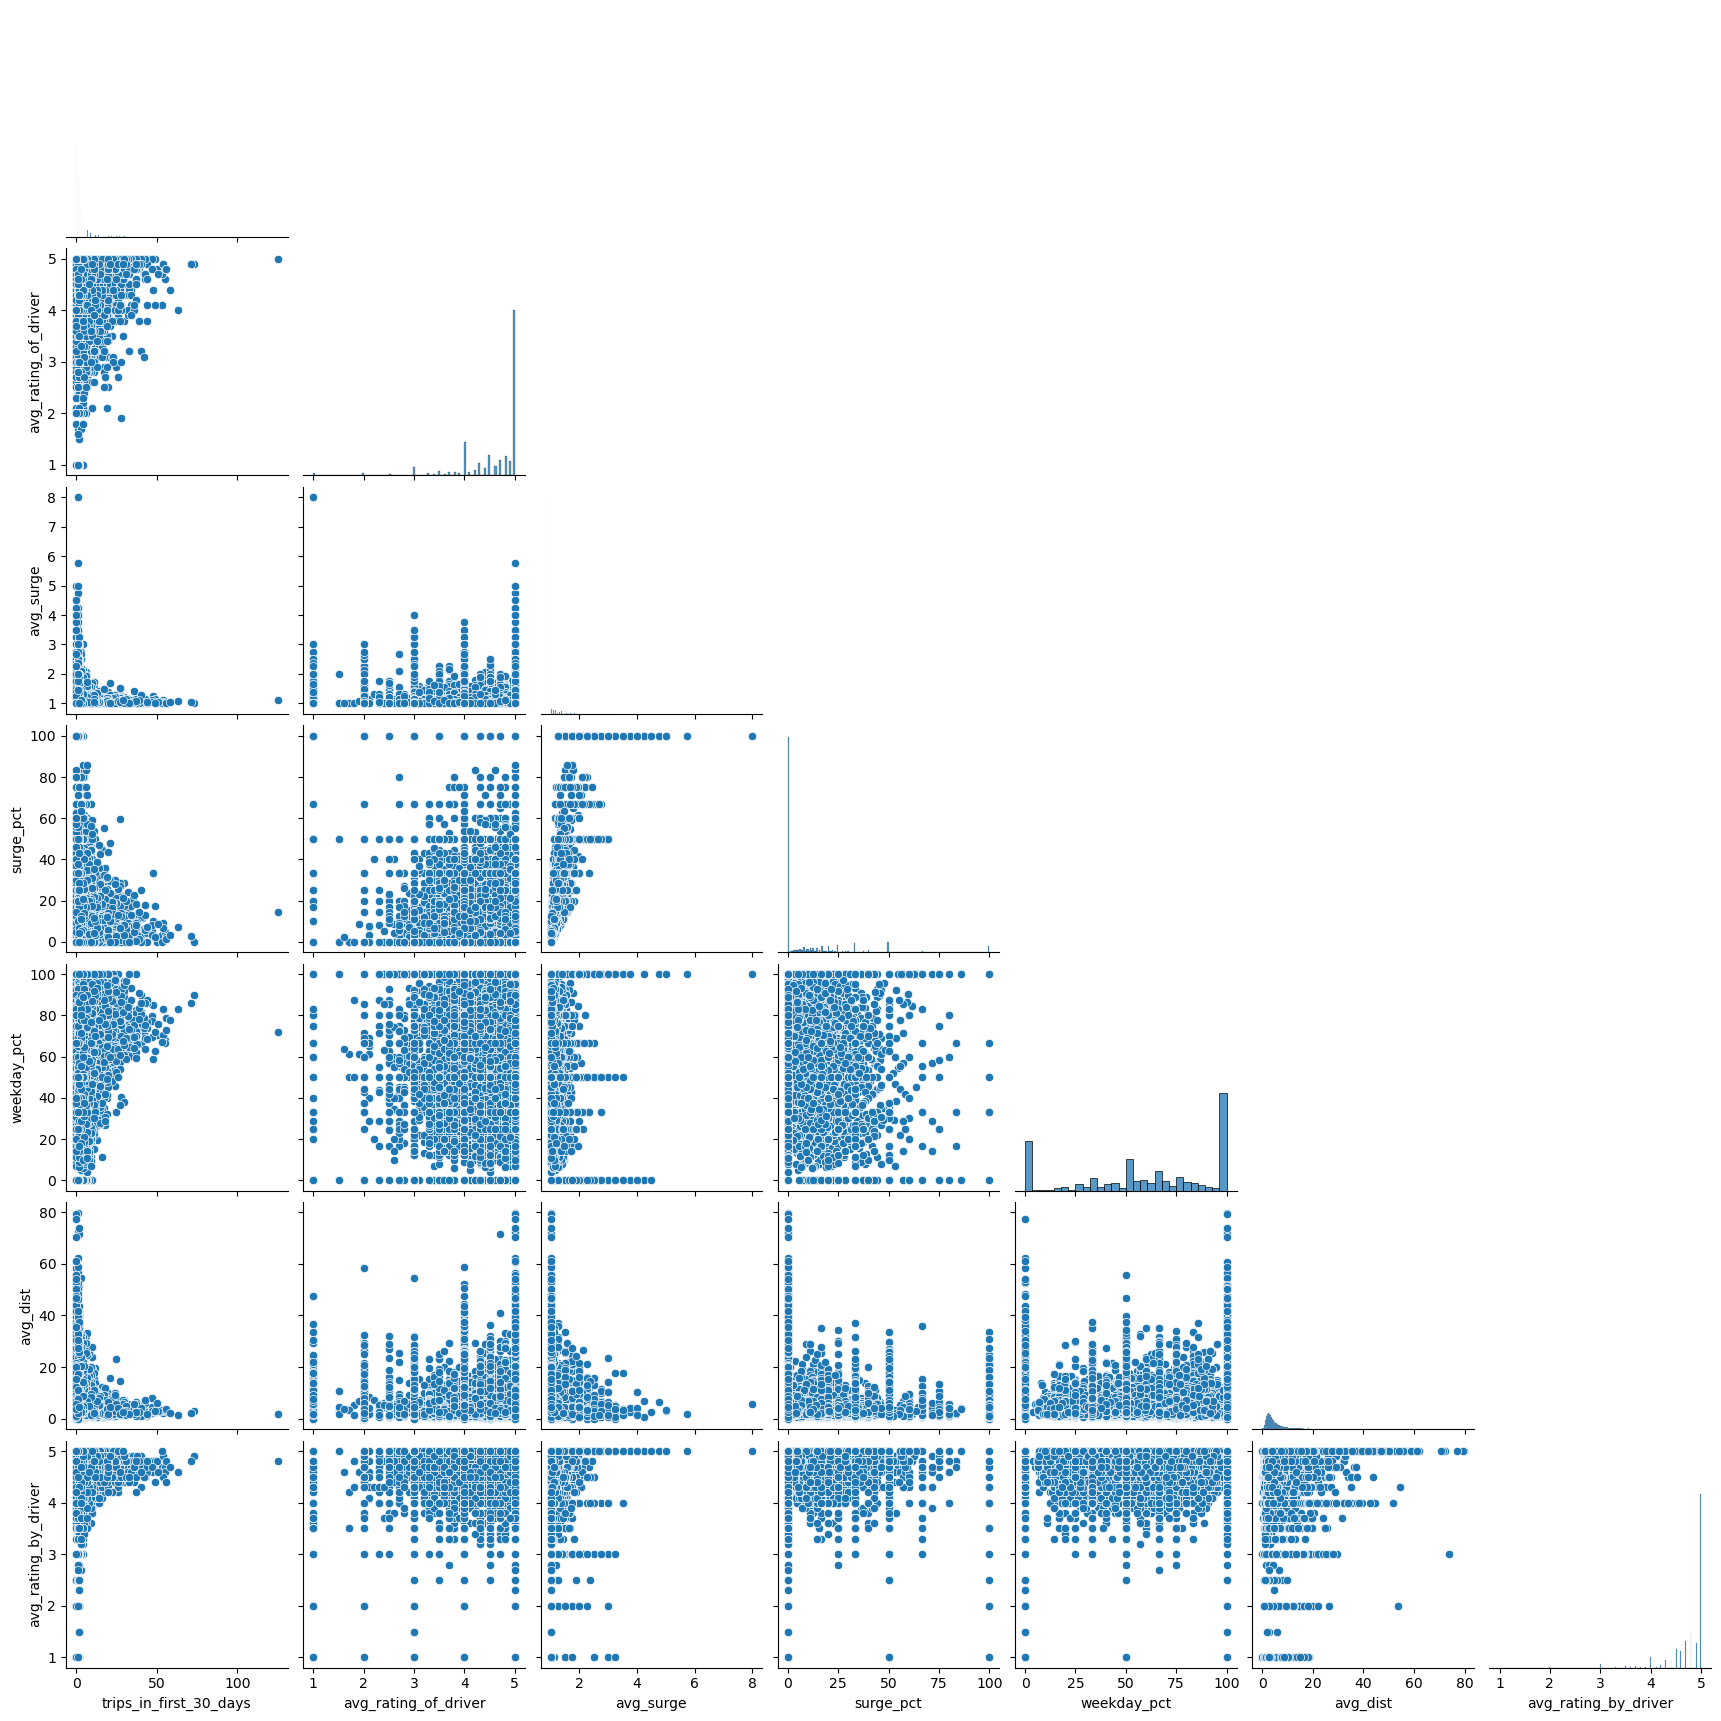

In [12]:
# view the correlations between continuous variables
sns.pairplot(df.drop(['city_Astapor',
                      'city_King\'s Landing',
                      'city_Winterfell',
                      'phone_Android',
                      'phone_iPhone',
                      'ultimate_black_user_False',
                      'ultimate_black_user_True'], axis=1), corner=True)
plt.show()

Some observations are:
1. Users that were rated poorly by the drivers did not take as many trips in the first 30 days of signup
2. surge percent appears to be inversely proportional to how many trips were taken by users within the first 30 days of signup

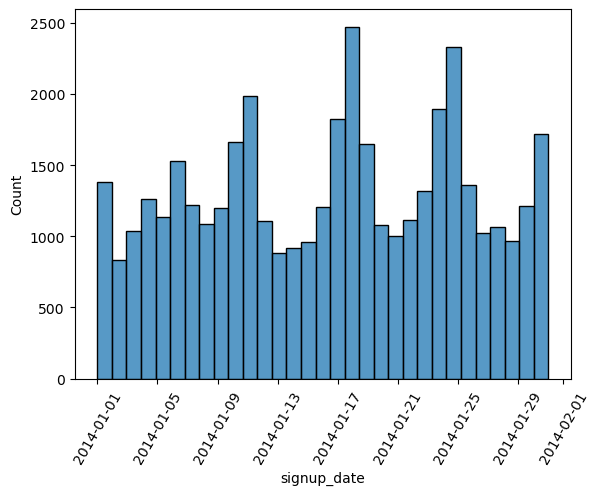

In [13]:
# view time series data
sns.histplot(data=df['signup_date'], bins=len(np.unique(df['signup_date'])))
plt.xticks(rotation=60)
plt.show()

The signup dates all fall within the month of January, as denoted by the problem statement. It appears that there are peaks of signups possibly during the weekends.

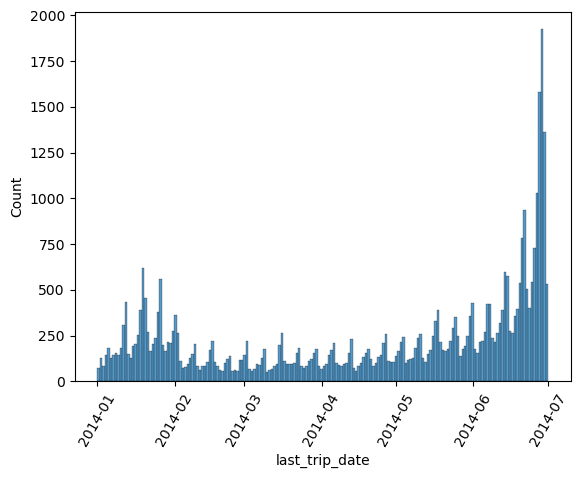

In [14]:
# view time series data
sns.histplot(data=df['last_trip_date'], bins=len(np.unique(df['last_trip_date'])))
plt.xticks(rotation=60)
plt.show()

It looks like there was an initial surge of one time users, since their last trip existed during their signup month, and then there's a steady decay of users of the following months. The peak of trips at the end of the plot is likely due to the users that are still active at the time the data was recorded.

In [15]:
# function to get month from row in dataframe
def get_month(date):
    return date.month

df_last_trip_date = df[['last_trip_date']].copy()
df_last_trip_date['month'] = df_last_trip_date['last_trip_date'].apply(get_month)
df_last_trip_date.head()

,last_trip_date,month
0,2014-06-17,6
1,2014-05-05,5
2,2014-01-07,1
3,2014-06-29,6
4,2014-03-15,3


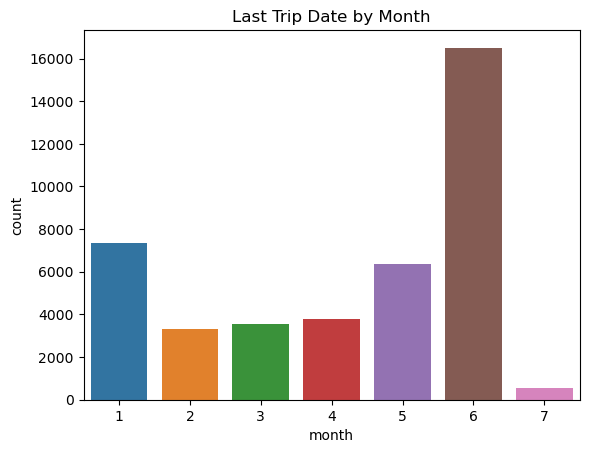

In [16]:
sns.countplot(data=df_last_trip_date, x='month')
plt.title('Last Trip Date by Month')
plt.show()

## What fraction of the observed users were retained?

In order to declare a user as active, we can only work up until the date of the most recent `last_trip_date`.

In [17]:
max(df['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

The most recent trip date recorded was 2014-07-01. So we can declare a user as active up until this date.

In [18]:
# calculate whether a user was active or not
max_date_minus_30_days = max(df['last_trip_date']) - datetime.timedelta(days=30)
df['active'] = df.apply(lambda row: row['last_trip_date'] > max_date_minus_30_days, axis=1)

In [19]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0,False
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0,False


In [20]:
df['active'].value_counts()

False    24837
True     16608
Name: active, dtype: int64

In [21]:
df['active'].value_counts(normalize=True)

False    0.599276
True     0.400724
Name: active, dtype: float64

In [22]:
perc_true = df['active'].value_counts(normalize=True)[1] * 100
max_date = max(df['last_trip_date'])
str(f'{round(perc_true, 2)}% of the observed users are still active, as of {max_date}')

'40.07% of the observed users are still active, as of 2014-07-01 00:00:00'

## Building a predictive model to determine whether or not a user will be active in their 6th month on the system

The task is to build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Declaring a user active or inactive will be a classification problem. To be considered active in their 6th month, the user must have taken a ride within 30 days from the end of their 6th month.

Step 1: Determine the last day of 6th month period for each user (as a function)

Step 2: Determine if the user was active on their xth month (as a function)

Step 3: Create a training dataset for predicting user retention on their xth month (as a function)

Step 4: Train a model for predicting user retention on their xth month, cross-validate, and predict (build a pipeline)

Step 4: Predict user retention on their 6th month

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
# function to determine the day a user has been signed up for x months
def get_user_x_month_date(signup_date, n_months):
    return datetime.date(signup_date.year, signup_date.month + n_months, signup_date.day)

# function to determine the last day that a user was/will be considered active
def get_user_last_date_active(last_trip_date):
    last_day_active = last_trip_date + datetime.timedelta(days=30)
    return last_day_active

In [25]:
# get date of 6 months on the system
df['6_month_day'] = df.apply(lambda row: get_user_x_month_date(row['signup_date'], 6), axis=1)
df['7_month_day'] = df.apply(lambda row: get_user_x_month_date(row['signup_date'], 7), axis=1)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,active,6_month_day,7_month_day
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1,True,2014-07-25,2014-08-25
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0,False,2014-07-29,2014-08-29
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0,False,2014-07-06,2014-08-06
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1,True,2014-07-10,2014-08-10
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0,False,2014-07-27,2014-08-27


In [26]:
# get laste date user is considered active
df['last_date_active'] = df.apply(lambda row: get_user_last_date_active(row['last_trip_date']), axis=1)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,active,6_month_day,7_month_day,last_date_active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1,True,2014-07-25,2014-08-25,2014-07-17
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0,False,2014-07-29,2014-08-29,2014-06-04
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0,False,2014-07-06,2014-08-06,2014-02-06
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1,True,2014-07-10,2014-08-10,2014-07-29
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0,False,2014-07-27,2014-08-27,2014-04-14


In [27]:
# check if any users were active during their 6th month
df['active'] = ((df['last_date_active'] >= (df['6_month_day'] - datetime.timedelta(days=30))) &
                (df['last_date_active'] < df['7_month_day']))
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,active,6_month_day,7_month_day,last_date_active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1,True,2014-07-25,2014-08-25,2014-07-17
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0,False,2014-07-29,2014-08-29,2014-06-04
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0,False,2014-07-06,2014-08-06,2014-02-06
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1,True,2014-07-10,2014-08-10,2014-07-29
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0,False,2014-07-27,2014-08-27,2014-04-14


In [28]:
df['active'].value_counts()

False    21288
True     20157
Name: active, dtype: int64

In [29]:
df['active'].value_counts(normalize=True)

False    0.513645
True     0.486355
Name: active, dtype: float64

Roughly 45% of users that signed up in January were active during their 6th month in the system (active meaning that they had taken a ride within the preceding 30 days from any date during their 6th month).

Now that we have the targets for the dataset created, we can separate the data into X and y dataframes where we will perform a train-test split.

In [30]:
# since sklearn's models do not handle datetimes, let's first extract features from the datetimes before converting to integers
df['signup_year'] = df['signup_date'].apply(lambda time: time.year)
df['signup_month'] = df['signup_date'].apply(lambda time: time.month)
df['signup_day'] = df['signup_date'].apply(lambda time: time.day)

df['last_trip_year'] = df['last_trip_date'].apply(lambda time: time.year)
df['last_trip_month'] = df['last_trip_date'].apply(lambda time: time.month)
df['last_trip_day'] = df['last_trip_date'].apply(lambda time: time.day)

df['signup_date_ordinal'] = df['signup_date'].apply(lambda time: time.toordinal())
df['last_trip_date_ordinal'] = df['last_trip_date'].apply(lambda time: time.toordinal())

df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,...,7_month_day,last_date_active,signup_year,signup_month,signup_day,last_trip_year,last_trip_month,last_trip_day,signup_date_ordinal,last_trip_date_ordinal
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,...,2014-08-25,2014-07-17,2014,1,25,2014,6,17,735258,735401
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,...,2014-08-29,2014-06-04,2014,1,29,2014,5,5,735262,735358
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,...,2014-08-06,2014-02-06,2014,1,6,2014,1,7,735239,735240
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,...,2014-08-10,2014-07-29,2014,1,10,2014,6,29,735243,735413
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,...,2014-08-27,2014-04-14,2014,1,27,2014,3,15,735260,735307


In [31]:
# create X and y
X = df.drop(['active', '6_month_day', '7_month_day', 'last_date_active', 'signup_date', 'last_trip_date'], axis=1)
y = df[['active']]

In [32]:
print(X.shape)
X.head()

(41445, 22)


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,...,ultimate_black_user_False,ultimate_black_user_True,signup_year,signup_month,signup_day,last_trip_year,last_trip_month,last_trip_day,signup_date_ordinal,last_trip_date_ordinal
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,...,0,1,2014,1,25,2014,6,17,735258,735401
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,...,1,0,2014,1,29,2014,5,5,735262,735358
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,...,1,0,2014,1,6,2014,1,7,735239,735240
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,...,0,1,2014,1,10,2014,6,29,735243,735413
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,...,1,0,2014,1,27,2014,3,15,735260,735307


In [33]:
print(y.shape)
y.head()

(41445, 1)


,active
0,True
1,False
2,False
3,True
4,False


In [34]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), random_state=42)

In [35]:
# standardize the X data based on the training set (assumes gaussian distribution, which not all data is)
#gridsearch the pipeline? each split should be scaled based on train set

pipe = make_pipeline(StandardScaler(), LogisticRegression())

pipe_parameters = [{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid = GridSearchCV(estimator=pipe, param_grid=pipe_parameters, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                    100]}])

In [36]:
grid.best_params_

{'logisticregression__C': 100}

In [37]:
preds = grid.predict(X_test)

In [38]:
def score_model_predictions(true, pred):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    f1 = f1_score(true, pred)
    
    return accuracy, precision, recall, f1

In [39]:
accuracy, precision, recall, f1 = score_model_predictions(y_test, preds)
print('accuracy: ' + str(round(accuracy, 3)))
print('precision: ' + str(round(precision, 3)))
print('recall: ' + str(round(recall, 3)))
print('f1: ' + str(round(f1, 3)))

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
